Build a linear model of the form:
$$
y = \beta_0 + \sum_{i=1}^8 \beta_i \cdot x_i + \sum_{i=1}^{n-1} x_i \cdot x_{i+1} ⋅ \beta_{8+i}, \text{where, } σ ~ \mathcal{N}(0,\, \sigma^2)\
$$
and consider:

1.   by using cross-validation, show a two dimensional projection of the probability distribution of parameters. Use a `jointplot` to show an estimate of the density function,
2.   by using cross-validation, show a two dimensional projection of the probability distribution of errors. Use a `kdeplot` to show an estimate of the density function,
3.   can we consider that errors are uncorrelated?,
4.   in average, what is the accuracy of this model?,
5.   estimate $\sigma$.

In all cases, set to 1000 the number of iterations for cross validation, comment as needed.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.stattools import durbin_watson
import patsy as pt

In [26]:
df_aba = pd.read_csv('archive.ics.uci.edu_ml_machine-learning-databases_abalone_abalone.data.csv',header=None);
df_aba.columns = [f'x{i}' for i in range(0,9)]; # crear las columnas como xi

df_aba.x8=df_aba.x8+1.5 # incrementar x8 en 1.5
df_aba.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,8.5
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,10.5
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,11.5
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,8.5


In [27]:
# Definiendo los términos individuales y cuadráticos
single_terms = '+'.join([f'x{i}' for i in range(1, 8)])
other_terms = '+'.join([f'x{i}*x{i+1}' for i in range(1, 7)])
formula = single_terms + "+" + other_terms
formula

'x1+x2+x3+x4+x5+x6+x7+x1:x2+x2:x3+x3:x4+x4:x5+x5:x6+x6:x7'

In [28]:
# Crear matrices de diseño y respuesta usando la fórmula actualizada
y, X = pt.dmatrices(f"x8 ~ {formula}", df_aba)
# Verificando el número de términos en la matriz de diseño
print(X.shape[1])

14


In [29]:
# Listas para almacenar los resultados de cada iteración de la validación cruzada
SC = []  # Scores o coeficiente de determinacion "R^2"
Ei = []  # Errores
Bi = []  # Coeficientes
Vi = []  # Varianza de los errores


# Realizar 1000 iteraciones de validación cruzada
for i in range(1000):
    # Dividir el dataset en conjuntos de entrenamiento y validación
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=i)

    # Entrenar el modelo de regresión lineal
    lr = LinearRegression(fit_intercept=False)
    lr.fit(X_train, y_train)

    # Calcular y almacenar el score (R²)
    SC.append(lr.score(X_val, y_val))

    # Calcular y almacenar los errores
    ei = (y_val - lr.predict(X_val)).ravel()
    Ei.append(ei)

    # Calcular y almacenar la varianza de los errores
    Vi.append(np.var(ei))

    # Almacenar los coeficientes del modelo
    Bi.append(lr.coef_.ravel())

## 1. by using cross-validation, show a two dimensional projection of the probability distribution of parameters. Use a `jointplot` to show an estimate of the density function,

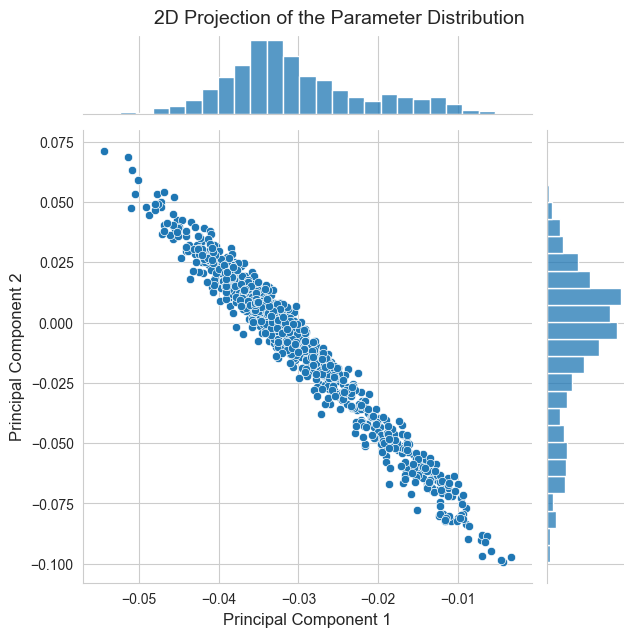

In [30]:
# Realizando la descomposición SVD para reducir la dimensionalidad de los coeficientes
U, S, Vt = np.linalg.svd(Bi, full_matrices=False)

# Estableciendo el estilo de la gráfica y creando un jointplot de los dos primeros componentes principales
sns.set_style('whitegrid')
joint_plot = sns.jointplot(x=U[:,0], y=U[:,1])
joint_plot.set_axis_labels('Principal Component 1', 'Principal Component 2', fontsize=12)
plt.suptitle('2D Projection of the Parameter Distribution', y=1.02, fontsize=14)

# Mostrando la gráfica
plt.show()

## 2. by using cross-validation, show a two dimensional projection of the probability distribution of errors. Use a `kdeplot` to show an estimate of the density function,

/var/folders/4x/by41vdp921s318y3mybq7fb80000gn/T/ipykernel_15486/448532065.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.sqrt(Vi),shade = True) # grafica varianza de lo errores


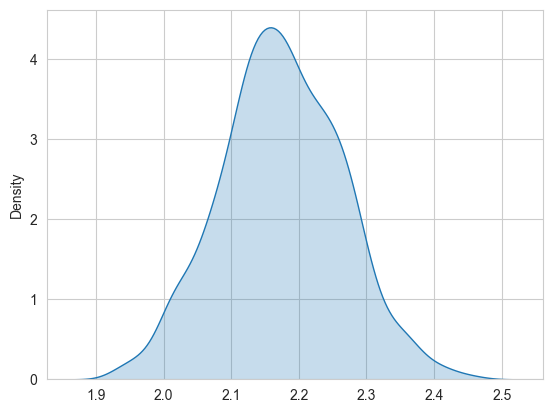

In [31]:
U,S,Vt = np.linalg.svd(Ei,full_matrices = False)
sns.set_style('whitegrid')
sns.kdeplot(np.sqrt(Vi),shade = True) # grafica varianza de lo errores
plt.show()

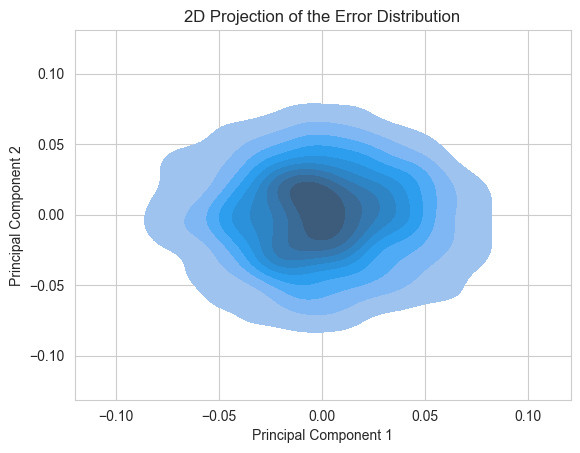

In [32]:
# Realizando la descomposición SVD para los errores
U, S, Vt = np.linalg.svd(Ei, full_matrices=False)

# Creando una kdeplot bidimensional para visualizar la distribución de los errores
sns.set_style('whitegrid')
sns.kdeplot(x=U[:,0], y=U[:,1], fill=True)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Projection of the Error Distribution')
plt.show()

### 3. can we consider that errors are uncorrelated?

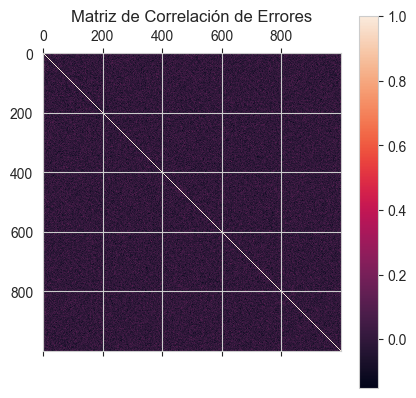

In [33]:
# Concatenando todas las listas de errores en una sola lista
all_errors = np.concatenate(Ei)

# Calculando la matriz de correlación de los errores
CORR = np.corrcoef(Ei)
plt.matshow(CORR)
plt.colorbar()
plt.title('Matriz de Correlación de Errores')
plt.show()

In [35]:
# Calculando el estadístico de Durbin-Watson para verificar la autocorrelación de los errores
dw = durbin_watson(all_errors)
print("Estadístico de Durbin-Watson:", dw)

# Interpretando el estadístico de Durbin-Watson
if dw < 1.5:
    print("La evidencia sugiere correlación positiva.")
elif 1.5 <= dw <= 2.5:
    print("La evidencia sugiere que los errores son no correlacionados.")
else:
    print("La evidencia sugiere correlación negativa.")


Estadístico de Durbin-Watson: 1.9950114212134664
La evidencia sugiere que los errores son no correlacionados.


## 4. in average, what is the accuracy of this model?

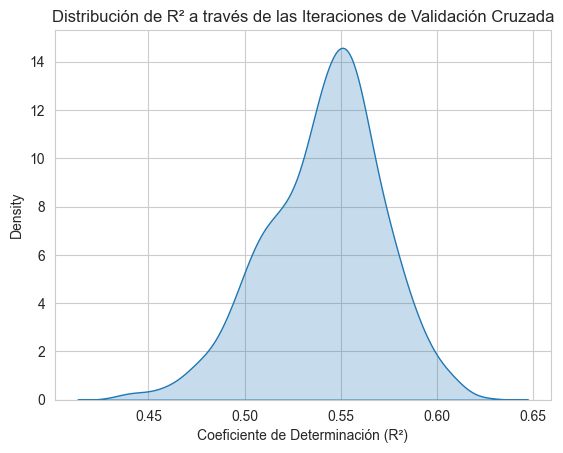

In [36]:
# Visualizando la distribución de los scores (coeficientes de determinación, R²)
sns.kdeplot(SC, fill=True)
plt.xlabel('Coeficiente de Determinación (R²)')
plt.title('Distribución de R² a través de las Iteraciones de Validación Cruzada')
plt.show()

In [38]:
# Calculando y mostrando la precisión promedio (mean R² score)
mean_score = np.mean(SC)
print(f"Precisión promedio del modelo (mean R² score): {mean_score}")

Precisión promedio del modelo (mean R² score): 0.5414406096763276


## 5. estimate $\sigma$.

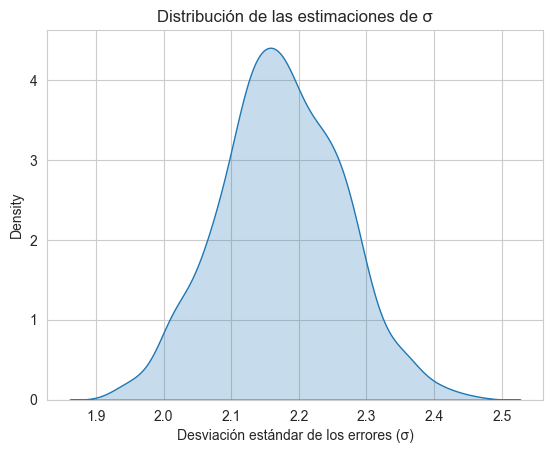

In [39]:
# Visualizando la distribución de las desviaciones estándar de los errores a través de las iteraciones
sns.kdeplot(np.sqrt(Vi), fill=True)
plt.xlabel('Desviación estándar de los errores (σ)')
plt.title('Distribución de las estimaciones de σ')
plt.show()

In [40]:
# Calculando y mostrando la desviación estándar de todos los errores
sigma_estimate = np.std(all_errors)
print(f"Estimación de σ: {sigma_estimate:.2f}")

Estimación de σ: 2.18
